In [1]:
import torch
import random
import numpy as np
from PIL import Image
from scipy.signal import convolve
from torchvision import transforms
import matplotlib.pyplot as plot

# 二维离散傅立叶变换与反变换
行最小基频为 $u\over M$ 列最小基频为 $v\over N$
$$
F(u,v)=\sum_{x=0}^{M-1}\sum_{y=0}^{N-1}f(x,y)\cdot e^{-2\pi j(\frac{xu}{M}+\frac{yv}{N})},u\in\{1,2,\cdots M\}\,and\,v\in\{1,2,\cdots N\}
$$
$$
f(x,y)=\frac{1}{M\cdot N}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F(u,v)\cdot e^{2\pi j(\frac{ux}{M}+\frac{vy}{N})},x\in\{1,2,\cdots M\}\,and\,y\in\{1,2,\cdots N\}
$$

变换求和次序即等价两次一维傅立叶变换
$$
\text{先对行作傅立叶变换,问题规模为}T(N),\text{复杂度}O(f(n))=O(N^2)=O(n^2)
$$
$$
\text{再对列作傅立叶变换,问题规模为}T(M),\text{复杂度}O(f(n))=O(M^2)=O(n^2)
$$

$$
F(u,v)=\sum_{x=0}^{M-1}\left[\sum_{y=0}^{N-1}f(x,y)\cdot e^{-2\pi j(\frac{vy}{N})}\right]\cdot e^{-2\pi j(\frac{ux}{M})}
$$

$$
f(x,y)=\frac{1}{M}\sum_{u=0}^{M-1}\left[\frac{1}{N}\sum_{v=0}^{N-1}F(u,v)\cdot e^{2\pi j(\frac{vy}{N})}\right]\cdot e^{2\pi j(\frac{ux}{M})}
$$

In [2]:
# 离散傅立叶变换, 计算复杂度 O((MN)^2), (744 µs ± 3.82 µs per loop)
def dft2d_dotloop(inputs):
    m, n = inputs.shape
    result = np.zeros((m, n), dtype=np.complex64)
    for u in range(m):
        for v in range(n):
            for x in range(m):
                for y in range(n):
                    result[u, v] += inputs[x, y] * np.exp(-2j * np.pi * (((x * u) / m) + ((y * v) / n)))

    return result

# 离散傅立叶反变换
def idft2d_dotloop(inputs):
    m, n = inputs.shape
    result = np.zeros((m, n), dtype=np.complex64)
    for x in range(m):
        for y in range(n):
            for u in range(m):
                for v in range(n):
                    result[x, y] += inputs[u, v] * np.exp(2j * np.pi * (((u * x) / m) + ((v * y) / n)))
    result /= (m*n)

    return result

a = np.array([[1, 1, 3, 5], [1, 1, 1, 1], [1, 1, 2, 1], [1, 1, 1, 1]])
b = np.random.randn(4, 4)

print(a,
      dft2d_dotloop(a),
      np.fft.fft2(a),
      idft2d_dotloop(dft2d_dotloop(a)),
      dft2d_dotloop(a)-np.fft.fft2(a), 
      idft2d_dotloop(dft2d_dotloop(a))-a, sep="\n\n")
print(b,
      dft2d_dotloop(b),
      np.fft.fft2(b),
      idft2d_dotloop(dft2d_dotloop(b)),
      dft2d_dotloop(b)-np.fft.fft2(b), 
      idft2d_dotloop(dft2d_dotloop(b))-a, sep="\n\n")

# 离散傅立叶变换向量化, (70.1 µs ± 214 ns per loop)
def dft2d_vectorloop(inputs):
    m, n = inputs.shape
    temp = np.zeros((m, n), dtype=np.complex64)
    result = np.zeros((m, n), dtype=np.complex64)
    for v in range(n):
        for y in range(n):
            temp[:, v] += inputs[:, y] * np.exp(-2j * np.pi * ((y * v) / n))
    for u in range(m):    
        for x in range(m):      
            result[u, :] += temp[x, :] * np.exp(-2j * np.pi * ((x * u) / m))

    return result

# 离散傅立叶反变换向量化
def idft2d_vectorloop(inputs):
    m, n = inputs.shape
    temp = np.zeros((m, n), dtype=np.complex64)
    result = np.zeros((m, n), dtype=np.complex64)
    for y in range(n):
        for v in range(n):
            temp[:, y] += inputs[:, v] * np.exp(2j * np.pi * ((v * y) / n))
    temp /= n 
    for x in range(m):    
        for u in range(m):      
            result[x, :] += temp[u, :] * np.exp(2j * np.pi * ((u * x) / m))
    result /= m 

    return result

a = np.array([[1, 1, 3, 5], [1, 1, 1, 1], [1, 1, 2, 1], [1, 1, 1, 1]])
b = np.random.randn(3, 3)

print(a,
      dft2d_vectorloop(a),
      np.fft.fft2(a),
      idft2d_vectorloop(dft2d_vectorloop(a)),
      dft2d_vectorloop(a)-np.fft.fft2(a), 
      idft2d_vectorloop(dft2d_vectorloop(a))-a, sep="\n\n")
print(b,
      dft2d_vectorloop(b),
      np.fft.fft2(b),
      idft2d_vectorloop(dft2d_vectorloop(b)),
      dft2d_vectorloop(b)-np.fft.fft2(b), 
      idft2d_vectorloop(dft2d_vectorloop(b))-b, sep="\n\n")

[[1 1 3 5]
 [1 1 1 1]
 [1 1 2 1]
 [1 1 1 1]]

[[23.+0.0000000e+00j -3.+4.0000000e+00j -1.-1.7145056e-15j
  -3.-4.0000000e+00j]
 [ 5.+0.0000000e+00j -1.+4.0000000e+00j -3.+0.0000000e+00j
  -1.-4.0000000e+00j]
 [ 7.-7.3478811e-16j -3.+4.0000000e+00j -1.-4.8985874e-16j
  -3.-4.0000000e+00j]
 [ 5.+0.0000000e+00j -1.+4.0000000e+00j -3.+0.0000000e+00j
  -1.-4.0000000e+00j]]

[[23.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]
 [ 7.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]]

[[1.+0.0000000e+00j 1.+4.1633363e-17j 3.-2.7755576e-17j 5.-1.3877788e-16j]
 [1.+4.1633363e-17j 1.-2.7755576e-17j 1.-1.3877788e-16j 1.+5.5511151e-17j]
 [1.-2.7755576e-17j 1.-1.3877788e-16j 2.+5.5511151e-17j 1.+6.8001160e-16j]
 [1.-1.3877788e-16j 1.+5.5511151e-17j 1.+6.8001160e-16j 1.-5.5511151e-17j]]

[[0.+0.00000000e+00j 0.+0.00000000e+00j 0.-1.71450565e-15j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.-7.34788112e-16j 0

# 快速傅立叶变换
FFT 优化了 DFT 计算复杂度, 使用分治的思想通过频域中心共轭对称规律不断优化为规模更小的 DFT
- 一维傅立叶变换有正交基, $F(u)$ 是基中的一组向量
$$
\left\{ 1, e^{-j\frac{xu}{M}} \right\}\; x\in[0, M)\; mod(M,2)=0
$$
DFT 可不断优化为原折半的 DFT（蝴蝶变换）
- 令 $e^{-j\frac{xu}{M}}$ 为 $y^x$, $k\in[0,{M \over 2})$
$$
\begin{aligned}
F(u)&=f_0y^0+f_1y^1+f_2y^2+f_3y^3\cdots+f_{M-2}\cdot y^{M-2}+f_{M-1}\cdot y^{M-1}\\
F_0(u)&=f_0y^0+f_2y^2+\cdots+f_{M-2}\cdot y^{M-2}=A_0(y^{2k})\\
F_1(u)&=f_1y^1+f_3y^3+\cdots+f_{M-1}\cdot y^{M-1}\\
&=y\cdot(f_1y^0+f_3y^2+\cdots+f_{M-2}\cdot y^{M-2})=y\cdot A_1(y^{2k})\\
\Rightarrow F(u)&=A_0(e^{-j\frac{2ku}{M}})+e^{-j\frac{u}{M}}\cdot A_1(e^{-j\frac{2ku}{M}})\\
F(u_{conj})&=A_0(e^{-j\frac{2ku}{M}})-e^{-j\frac{u}{M}}\cdot A_1(e^{-j\frac{2ku}{M}})\\
\vdots\\
&\text{重复上述步骤直到无法分解,构成满二叉树,高度为}log_2^M\\
&\text{满二叉树的每层仅一半节点需乘法运算并求和全部节点,问题规模为}T(M)\\
&\text{复杂度O(f(n))}=2O({M\over 2})+M=2(2O({M\over 4})+{M\over 2})+M\cdots=2^{log_2^M}O(1)+Mlog_2^M=O(nlog_2^n)
\end{aligned}
$$

In [3]:
# 快速傅立叶变换, (137 µs ± 911 ns per loop)
def fft2d_divideloop(inputs):
    m, n = inputs.shape
    # fft 需要保证序列是 2^n, 否则补零
    if 2**np.ceil(np.log2(m)) != m:
        inputs = np.pad(inputs, ((0, int(2**np.ceil(np.log2(m))-m)), (0, 0)), 'constant', constant_values=(0, 0))
    if 2**np.ceil(np.log2(n)) != n:
        inputs = np.pad(inputs, ((0, 0), (0, int(2**np.ceil(np.log2(n))-n))), 'constant', constant_values=(0, 0))
    m, n = inputs.shape    
    result = np.zeros((m, n), dtype=np.complex64) 
    for v in range(n):
        result[:, v] = fft1d_divideloop(inputs[:, v])    
    for u in range(m):
        result[u, :] = fft1d_divideloop(result[u, :])

    return result

# 快速傅立叶反变换
def ifft2d_divideloop(inputs):
    m, n = inputs.shape
    if 2**np.ceil(np.log2(m)) != m:
        inputs = np.pad(inputs, ((0, int(2**np.ceil(np.log2(m))-m)), (0, 0)), 'constant', constant_values=(0, 0))
    if 2**np.ceil(np.log2(n)) != n:
        inputs = np.pad(inputs, ((0, 0), (0, int(2**np.ceil(np.log2(n))-n))), 'constant', constant_values=(0, 0))
    m, n = inputs.shape
    result = np.zeros((m, n), dtype=np.complex64) 
    for y in range(n):
        result[:, y] = ifft1d_divideloop(inputs[:, y])    
    for x in range(m):
        result[x, :] = ifft1d_divideloop(result[x, :])
    
    return result

def fft1d_divideloop(inputs):
    l = len(inputs)
    ll = int(np.log2(l))
    # 通过二进制编码重排数据两两组成一对计算元
    vector = np.array(reset_data(inputs), dtype=np.complex128)
    for i in range(ll):
        m = 2**(i+1)
        ym = np.exp(-1.j * 2 * np.pi / m)
        for j in range(0, l, m):
            y = 1
            for k in range(m//2):
                c0 = vector[k+j] 
                c1 = vector[k+j+m//2] * y
                vector[k+j] = c0 + c1
                vector[k+j+m//2] = c0 - c1
                y *= ym
                
    return vector

def ifft1d_divideloop(inputs):
    l = len(inputs)
    ll = int(np.log2(l))
    vector = np.array(reset_data(inputs), dtype=np.complex128)
    for i in range(ll):
        m = 2**(i+1)
        ym = np.exp(1.j * 2 * np.pi / m)
        for j in range(0, l, m):
            y = 1
            for k in range(m//2):
                c0 = vector[k+j] 
                c1 = vector[k+j+m//2] * y
                vector[k+j] = c0 + c1
                vector[k+j+m//2] = c0 - c1
                y *= ym
    vector /= l  
              
    return vector
    
def reset_data(inputs):
    l = len(inputs)
    outputs = np.zeros(l, dtype=np.complex128)
    for i in range(l):
        j = int(reverse_bin(i, l), 2)
        outputs[j] = inputs[i]
        
    return outputs    

def reverse_bin(numbers, length):
    bin_str = bin(numbers)[2:]
    if len(bin_str) <= np.log2(length):
        bin_str = ("0"*(int(np.log2(length)-len(bin_str))) + bin_str)[::-1]
    
    return bin_str

a = np.array([[1, 1, 3, 5], [1, 1, 1, 1], [1, 1, 2, 1], [1, 1, 1, 1]])
b = np.random.randn(3, 3)

print(a,
      fft2d_divideloop(a),
      np.fft.fft2(a),
      ifft2d_divideloop(fft2d_divideloop(a)),
      fft2d_divideloop(a)-np.fft.fft2(a), 
      ifft2d_divideloop(fft2d_divideloop(a))-a, sep="\n\n")
print(b,
      fft2d_divideloop(b),
      np.fft.fft2(b),
      ifft2d_divideloop(fft2d_divideloop(b))[:-1,:-1],
      fft2d_divideloop(b)[:-1,:-1]-np.fft.fft2(b), 
      ifft2d_divideloop(fft2d_divideloop(b))[:-1,:-1]-b, sep="\n\n")

[[1 1 3 5]
 [1 1 1 1]
 [1 1 2 1]
 [1 1 1 1]]

[[23.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]
 [ 7.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]]

[[23.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]
 [ 7.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]]

[[1.+0.0000000e+00j 1.+1.2246469e-16j 3.+0.0000000e+00j 5.-1.2246469e-16j]
 [1.+0.0000000e+00j 1.+0.0000000e+00j 1.+0.0000000e+00j 1.+0.0000000e+00j]
 [1.+0.0000000e+00j 1.+0.0000000e+00j 2.+0.0000000e+00j 1.+0.0000000e+00j]
 [1.+0.0000000e+00j 1.+0.0000000e+00j 1.+0.0000000e+00j 1.+0.0000000e+00j]]

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

[[0.+0.00000000e+00j 0.+1.22464685e-16j 0.+0.00000000e+00j
  0.-1.22464685e-16j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]

# 卷积定理
空域的卷积对应傅里叶变换后频域的乘积

$$
\mathcal{F^{-1}}\{f(a)\ast f(b)\}=\mathcal{F}\{f(a)\}\cdot\mathcal{F}\{f(b)\}
$$

空域乘积的傅里叶变换等于空域傅里叶变换后频域的乘积

$$
\frac{1}{2\pi}\mathcal{F}\{f(a)\}\ast\mathcal{F}\{f(b)\}=\mathcal{F}\{f(a)\cdot f(b)\}
$$

傅立叶变换是线性的, 卷积核可视为冲激函数的线性组合, 卷积核的尺寸即冲激函数的定义域, 则可利用平移性质与缩放性质证明

In [4]:
# 构造数据
a = torch.arange(0,9,1).reshape(3,3).type(torch.float32)
b = torch.randn(3,3)
pad_size = 1
a_pad = torch.nn.functional.pad(a, [pad_size]*4, value=0)
b_pad = torch.nn.functional.pad(b, [pad_size]*4, value=0)

print(f"a:\n{a}\na {a.shape}", f"b:\n{b}\nb {b.shape}",
      f"a_pad_centre:\n{a_pad[pad_size:pad_size+3, pad_size:pad_size+3]}\na_pad {a_pad.shape}",
      f"b_pad_centre:\n{b_pad[pad_size:pad_size+3, pad_size:pad_size+3]}\nb_pad {b_pad.shape}", sep="\n")

"""
通过
b = torch.fft.fftshift(torch.fft.fft2(a))
c = torch.fft.ifftshift(torch.fft.ifft2(b.conj()))
得a的中心对称c
或者
b = torch.fft.fft2(a)
c = torch.fft.ifftshift(torch.fft.ifft2(b.conj()))
幅度对但相位错
"""

a:
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
a torch.Size([3, 3])
b:
tensor([[-0.1075,  0.8014,  1.4777],
        [-0.5583,  1.0979, -0.3993],
        [-1.2961, -0.7370, -0.7754]])
b torch.Size([3, 3])
a_pad_centre:
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
a_pad torch.Size([5, 5])
b_pad_centre:
tensor([[-0.1075,  0.8014,  1.4777],
        [-0.5583,  1.0979, -0.3993],
        [-1.2961, -0.7370, -0.7754]])
b_pad torch.Size([5, 5])


'\n通过\nb = torch.fft.fftshift(torch.fft.fft2(a))\nc = torch.fft.ifftshift(torch.fft.ifft2(b.conj()))\n得a的中心对称c\n或者\nb = torch.fft.fft2(a)\nc = torch.fft.ifftshift(torch.fft.ifft2(b.conj()))\n幅度对但相位错\n'

In [5]:
# 空域卷积
result = convolve(a, b, 'same')
result_ab = torch.conv2d(a.unsqueeze(0).unsqueeze(0), b.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)
# c是b的中心对称即反转核
c = torch.arange(9,0,-1).reshape(3,3).type(torch.float32)
result_ac = torch.conv2d(a.unsqueeze(0).unsqueeze(0), c.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)

print(f"signal-convolve(ab):\n{result}\nis real convolution operation",
      f"pytorch-conv2d(ab):\n{result_ab}\nis noly correlation operation",
      f"c:\n{c}\nc {c.shape}",
      f"pytorch-conv2d(ac):\n{result_ac}\ncorrelation equal real convolution after inverter kernel", sep="\n\n")

signal-convolve(ab):
[[  1.416144    7.082695   11.7143345]
 [  3.8206682  10.689125   18.397898 ]
 [ -4.716382  -10.932173   -0.7989712]]
is real convolution operation

pytorch-conv2d(ab):
tensor([[ -5.7121, -10.4143,  -7.2321],
        [ -6.6761, -14.6625, -10.2173],
        [ 12.1070,  11.4124,   8.4522]])
is noly correlation operation

c:
tensor([[9., 8., 7.],
        [6., 5., 4.],
        [3., 2., 1.]])
c torch.Size([3, 3])

pytorch-conv2d(ac):
tensor([[ 14.,  35.,  38.],
        [ 57., 120., 111.],
        [110., 197., 158.]])
correlation equal real convolution after inverter kernel


In [6]:
# 测试傅立叶变换与反变换是否可逆
a_k1 = torch.fft.fft2(a)
b_k1 = torch.fft.fft2(b)
a_k2 = torch.fft.fftshift(torch.fft.fft2(a))
b_k2 = torch.fft.fftshift(torch.fft.fft2(b))
a_k3 = torch.fft.fft2(torch.fft.fftshift(a))
b_k3 = torch.fft.fft2(torch.fft.fftshift(b))

print(f"1.a-fft-ifft:\n{torch.fft.ifft2(a_k1)}\nis right reversible operation",
      f"2.a-fft-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(a_k1))}\nneed use fftshift and ifftshift operation in pairs",
      f"3.a-fft-ifftshift-ifft:\namplitude\n{torch.fft.ifft2(torch.fft.ifftshift(a_k1)).abs()}\nphase\n{torch.fft.ifft2(torch.fft.ifftshift(a_k1)).angle()}\namplitude is right but phase is wrong",
      f"4.a-fft-fftshift-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(a_k2))}\nis wrong operation",
      f"5.a-fft-fftshift-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(a_k2))}\nis right reversible operation",
      f"6.a-fft-fftshift-ifft:\namplitude\n{torch.fft.ifft2(a_k2).abs()}\nphase\n{torch.fft.ifft2(a_k2).angle()}\namplitude is right but phase is wrong",
      f"7.a-fftshift-fft-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(a_k3))}\nis wrong operation",
      f"8.a-fftshift-fft-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(a_k3))}\nis wrong operation",
      f"9.a-fftshift-fft-ifft:\n{torch.fft.ifft2(a_k3)}\nis wrong operation", sep="\n\n")

d = torch.rand((3,3), dtype=torch.complex128)
d_pad = torch.nn.functional.pad(d, [1]*4, value=0)
d_pad_k1 = torch.fft.fft2(d_pad)

print(f"\n10.complex d\n{d_pad}\nfft-ifft:\n", torch.fft.ifft2(d_pad_k1))
       
a_k11 = a_k1.reshape(-1)
index = [i for i in range(0,9,1)]
random.shuffle(index)
a_k12 = torch.empty_like(a_k11)
for i, j in enumerate(index):
    a_k12[j] = a_k11[i]
a_k13 = a_k12.reshape(3,3)

print(f"\n11.fft-shuffe k-space-ifft:\n", torch.fft.ifft2(a_k13))
     
"""     
结论: 
1.fft与ifft是一组可逆操作
2.平移fftshift通常使得低频在中心高频在四周是为了分析频谱图
3.理论上[可通过fourier变换平移定理先把原始图像做变换再做fft]或者[先做fft后再根据频域图像的对称性做对称变换]
4.fftshift和逆平移ifftshift是后一种直接在频域上进行移动
5.错误的fftshift和逆平移ifftshift使用顺序会导致结果出错
""" 

1.a-fft-ifft:
tensor([[0.+0.j, 1.+0.j, 2.+0.j],
        [3.+0.j, 4.+0.j, 5.+0.j],
        [6.+0.j, 7.+0.j, 8.+0.j]])
is right reversible operation

2.a-fft-ifft-ifftshift:
tensor([[4.+0.j, 5.+0.j, 3.+0.j],
        [7.+0.j, 8.+0.j, 6.+0.j],
        [1.+0.j, 2.+0.j, 0.+0.j]])
need use fftshift and ifftshift operation in pairs

3.a-fft-ifftshift-ifft:
amplitude
tensor([[0.0000, 1.0000, 2.0000],
        [3.0000, 4.0000, 5.0000],
        [6.0000, 7.0000, 8.0000]])
phase
tensor([[ 0.0000e+00, -2.0944e+00,  2.0944e+00],
        [-2.0944e+00,  2.0944e+00,  0.0000e+00],
        [ 2.0944e+00, -3.4060e-08, -2.0944e+00]])
amplitude is right but phase is wrong

4.a-fft-fftshift-ifft-ifftshift:
tensor([[-2.0000-3.4641e+00j,  5.0000+0.0000e+00j, -1.5000+2.5981e+00j],
        [ 7.0000+2.3842e-07j, -4.0000+6.9282e+00j, -3.0000-5.1962e+00j],
        [-0.5000+8.6603e-01j, -1.0000-1.7321e+00j,  0.0000+0.0000e+00j]])
is wrong operation

5.a-fft-fftshift-ifftshift-ifft:
tensor([[0.+0.j, 1.+0.j, 2.+0.j],
   

'     \n结论: \n1.fft与ifft是一组可逆操作\n2.平移fftshift通常使得低频在中心高频在四周是为了分析频谱图\n3.理论上[可通过fourier变换平移定理先把原始图像做变换再做fft]或者[先做fft后再根据频域图像的对称性做对称变换]\n4.fftshift和逆平移ifftshift是后一种直接在频域上进行移动\n5.错误的fftshift和逆平移ifftshift使用顺序会导致结果出错\n'

In [164]:
# 测试频域卷积定理
result_k1 = a_k1 * b_k1
result_k2 = a_k2 * b_k2
result_k3 = a_k3 * b_k3
a_pad_k1 = torch.fft.fft2(a_pad)
b_pad_k1 = torch.fft.fft2(b_pad)
a_pad_k2 = torch.fft.fftshift(torch.fft.fft2(a_pad))
b_pad_k2 = torch.fft.fftshift(torch.fft.fft2(b_pad))
a_pad_k3 = torch.fft.fft2(torch.fft.fftshift(a_pad))
b_pad_k3 = torch.fft.fft2(torch.fft.fftshift(b_pad))
result_pad_k1 = a_pad_k1 * b_pad_k1
result_pad_k2 = a_pad_k2 * b_pad_k2
result_pad_k3 = a_pad_k3 * b_pad_k3

e = torch.randn((3,3), dtype=torch.complex128)
e_pad = torch.nn.functional.pad(e, [1]*4, value=0)
result_pad = convolve(d, e, 'same')
e_pad_k1 = torch.fft.fft2(e_pad)
result_pad_k4 = e_pad_k1 * d_pad_k1

print(f"complex conv:\n{result_pad}", f"0.result-fft-(de)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_pad_k4))[1:4,1:4]}", sep="\n\n")

print(
      f"1.result-fft-(ab)-ifft:\n{torch.fft.ifft2(result_k1)}",
      f"2.result-fft-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_k1))}",
      f"3.result-fft-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_k1))}",
      f"4.result-fft-fftshift-(ab)-ifft:\n{torch.fft.ifft2(result_k2)}",
      f"5.result-fft-fftshift-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_k2))}",
      f"6.result-fft-fftshift-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_k2))}",
      f"7.result-fftshift-fft-(ab)-ifft:\n{torch.fft.ifft2(result_k3)}",
      f"8.result-fftshift-fft-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_k3))}",
      f"9.result-fftshift-fft-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_k3))}",
      "all is wrong be due to different from the actual convolution operation need pad zero", sep="\n\n"
)

print(
      "对空域原始图像进行补零提高频域精度",
      f"1.result_pad-fft-(ab)-ifft:\n{torch.fft.ifft2(result_pad_k1)[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"2.result_pad-fft-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_pad_k1))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"3.result_pad-fft-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_pad_k1))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"4.result_pad-fft-fftshift-(ab)-ifft:\n{torch.fft.ifft2(result_pad_k2)[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"5.result_pad-fft-fftshift-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_pad_k2))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"6.result_pad-fft-fftshift-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_pad_k2))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"7.result_pad-fftshift-fft-(ab)-ifft:\n{torch.fft.ifft2(result_pad_k3)[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"8.result_pad-fftshift-fft-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_pad_k3))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"9.result_pad-fftshift-fft-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_pad_k3))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      "only 3 is right operation and 6 amplitude is right but phase is wrong", sep="\n\n"
)

"""     
结论: 
1.空域卷积定理实现的严格操作顺序:[先进行傅立叶变换fft,接着进行频域点乘,然后进行傅立叶反变换ifft,最后进行平移ifftshift]
""" 

complex conv:
[[-1.07580643-0.71033082j -0.0632657 -0.62569138j -0.14987516+0.17276975j]
 [-0.99139409-1.26810433j  0.64639005-0.5293978j   0.45730436-0.17167671j]
 [-1.09194184-0.25787399j  1.07932259-0.40541701j  1.06696421-0.177788j  ]]

0.result-fft-(de)-ifft-ifftshift:
tensor([[-1.0758-0.7103j, -0.0633-0.6257j, -0.1499+0.1728j],
        [-0.9914-1.2681j,  0.6464-0.5294j,  0.4573-0.1717j],
        [-1.0919-0.2579j,  1.0793-0.4054j,  1.0670-0.1778j]],
       dtype=torch.complex128)
1.result-fft-(ab)-ifft:
tensor([[  5.7245-1.2622e-06j, -17.1229+8.1018e-07j,  21.8133-5.0326e-07j,
          ..., -13.4907-1.1280e-06j,   9.0800-9.7813e-07j,
          29.9592-1.5357e-06j],
        [  2.9434-6.4119e-07j,   2.0186+1.0437e-06j,   2.8125-1.8033e-07j,
          ...,   7.1031+1.6484e-06j,  17.5525+3.0214e-07j,
           9.8521-1.0091e-07j],
        [ 11.9988-1.5240e-06j,   4.4388-1.4357e-07j,   5.4334-6.9912e-07j,
          ...,   9.9060-2.4860e-06j,  19.1936+1.9097e-06j,
          -2.8698-2.

'     \n结论: \n1.空域卷积定理实现的严格操作顺序:[先进行傅立叶变换fft,接着进行频域点乘,然后进行傅立叶反变换ifft,最后进行平移ifftshift]\n'

In [98]:
# TODO FFt的频域卷积定理的实现尚存问题
d_k1 = torch.fft.fft2(d)
e_k1 = torch.fft.fft2(e)
f1 = torch.tensor(convolve(d_k1, e_k1, "same"))

pad_size = 1
d_k1_pad = torch.nn.functional.pad(d_k1, [pad_size]*4, value=0)
e_k1_pad = torch.nn.functional.pad(e_k1, [pad_size]*4, value=0)
d_1 = torch.fft.ifft2(d_k1_pad).abs()
e_1 = torch.fft.ifft2(e_k1_pad).abs()

f2 = (torch.fft.fft2(d_1 * e_1))[1:4,1:4]

print(
      f"1.f-convolution(F(d)F(e)):\n{f1.abs()}\n{f1.angle()}",
      f"2.f-(de)-fft-ifftshift:\n{f2.abs()}\n{f2.angle()}", sep="\n"
)

print(
      d,
      "\n",
      torch.fft.ifft2(d_k1)
)

1.f-convolution(F(d)F(e)):
tensor([[18.6270,  8.0384,  1.0745],
        [10.0578, 22.1986,  4.1978],
        [ 5.0215,  1.9232,  8.3066]], dtype=torch.float64)
tensor([[ 1.2787,  1.2970,  0.5816],
        [-0.9589, -0.8716,  3.1306],
        [ 2.6109,  2.0886, -0.2785]], dtype=torch.float64)
2.f-(de)-fft-ifftshift:
tensor([[0.3069, 0.1524, 0.0878],
        [0.2407, 0.3718, 0.0709],
        [0.0263, 0.0709, 0.3718]], dtype=torch.float64)
tensor([[-0.3427,  0.6709,  1.7607],
        [-2.0709, -2.2250,  0.2659],
        [ 2.0381, -0.2659,  2.2250]], dtype=torch.float64)
tensor([[0.5654+0.3788j, 0.2323+0.6156j, 0.4135+0.3056j],
        [0.4815+0.2717j, 0.9681+0.9389j, 0.9674+0.1736j],
        [0.8624+0.4818j, 0.6677+0.1848j, 0.3071+0.7375j]],
       dtype=torch.complex128) 
 tensor([[0.5654+0.3788j, 0.2323+0.6156j, 0.4135+0.3056j],
        [0.4815+0.2717j, 0.9681+0.9389j, 0.9674+0.1736j],
        [0.8624+0.4818j, 0.6677+0.1848j, 0.3071+0.7375j]],
       dtype=torch.complex128)


# 实践

In [17]:
# 加载图像
path = r'/Users/WangHao/工作/纳米光子中心/全光相关/实验-0303/0303.png'
img = Image.open(path).convert('L')
img = transforms.Compose([transforms.ToTensor(), transforms.Resize((201, 201))])(img)
img = img.squeeze(0)
img_k = torch.fft.fft2(img)

Text(0.5, 1.0, 'Get Central Symmetry')

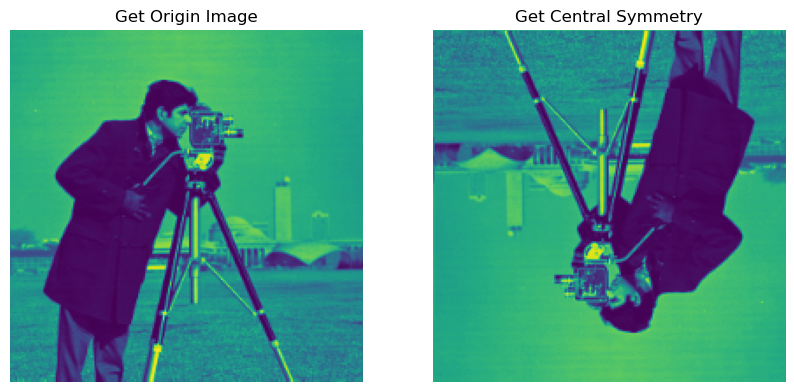

In [18]:
# 傅立叶变换与逆变换
img_1 = torch.fft.ifft2(img_k)
# 连续两次傅立叶变换等价原图中心对称
img_2 = torch.fft.fft2(img_k)
plot.figure("contrast", figsize=(10,20))
plot.subplot(121)
plot.imshow(img_1.abs())
plot.axis("off")
plot.title("Get Origin Image")
plot.subplot(122)
plot.imshow(img_2.abs())
plot.axis("off")
plot.title("Get Central Symmetry")

'\n结论:\n1.通过傅立叶变换在频域可以实现卷积运算即频域卷积\n2.进行频域卷积时至少需要补一圈零否则边界上会与空域卷积（空域卷积为了保证大小通常都会补零）不匹配\n'

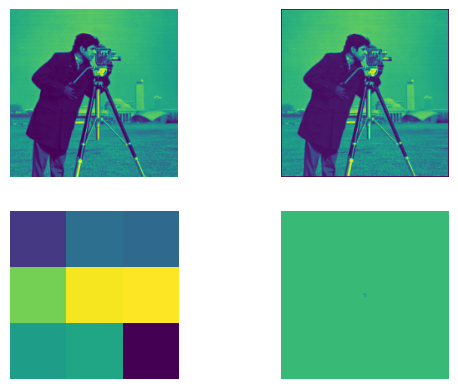

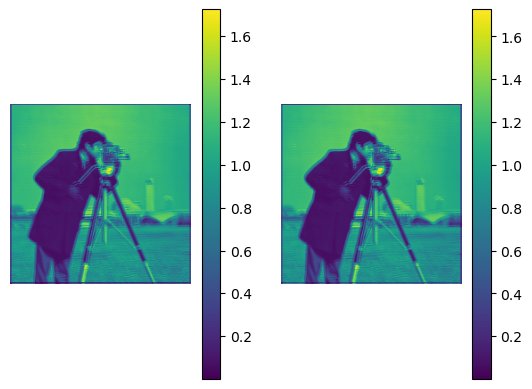

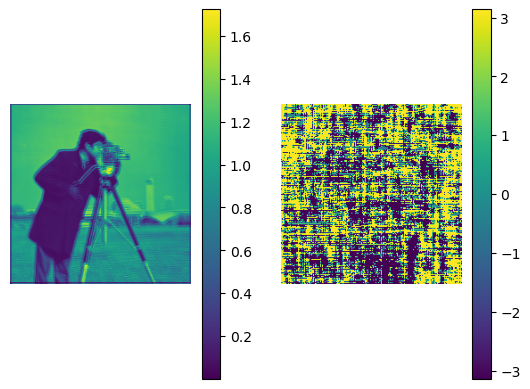

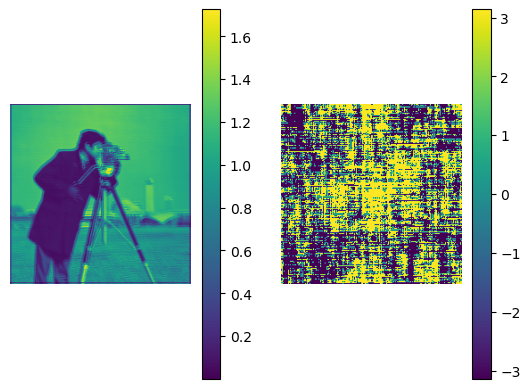

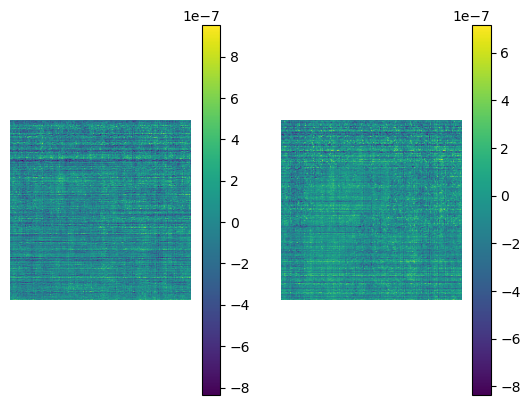

In [22]:
# 比较空域卷积与频域卷积
a = torch.arange(1, 10, 1).reshape(3, 3).float()
a = torch.tensor([[1., 1, 1], [1, -8, 1], [1, 1, 1]])
a = torch.rand(3, 3)
a = torch.randn(3,3)

img_1 = torch.nn.functional.pad(img, [1, 1, 1, 1], value=0)
img_k_1 = torch.fft.fft2(img_1)

b = torch.nn.functional.pad(a, [100, 100, 100, 100], value=0)
b_k_1 = torch.fft.fft2(b)
b_k_1_conj = torch.fft.fft2(b.reshape(-1).flipud().reshape(203, 203))

# 卷积运算
result1 = torch.tensor(convolve(img_1, a, 'same'))
# 相关运算
result2 = torch.conv2d(img_1.unsqueeze(0).unsqueeze(0),
                       a.unsqueeze(0).unsqueeze(0),
                       padding=1).squeeze(0).squeeze(0)
# 卷积运算
result3 = torch.fft.ifftshift(torch.fft.ifft2(img_k_1 * b_k_1))
# 相关运算
result4 = torch.fft.ifftshift(torch.fft.ifft2(img_k_1 * b_k_1_conj))

error1 = result1.abs() - result3.abs()
error2 = result2.abs() - result4.abs()

plot.figure(0)
plot.subplot(221)
plot.imshow(img)
plot.axis("off")
plot.subplot(222)
plot.imshow(img_1)
plot.axis("off")
plot.subplot(223)
plot.imshow(a)
plot.axis("off")
plot.subplot(224)
plot.imshow(b)
plot.axis("off")

plot.figure(1)
plot.subplot(121)
plot.imshow(result1.abs())
plot.axis("off")
plot.colorbar()
plot.subplot(122)
plot.imshow(result2.abs())
plot.axis("off")
plot.colorbar()

plot.figure(2)
plot.subplot(121)
plot.imshow(result3.abs())
plot.axis("off")
plot.colorbar()
plot.subplot(122)
plot.imshow(result3.angle())
plot.axis("off")
plot.colorbar()

plot.figure(3)
plot.subplot(121)
plot.imshow(result4.abs())
plot.axis("off")
plot.colorbar()
plot.subplot(122)
plot.imshow(result4.angle())
plot.axis("off")
plot.colorbar()

plot.figure(4)
plot.subplot(121)
plot.imshow(error1)
plot.axis("off")
plot.colorbar()
plot.subplot(122)
plot.imshow(error2)
plot.axis("off")
plot.colorbar()

"""
结论:
1.通过傅立叶变换在频域可以实现卷积运算即频域卷积
2.进行频域卷积时至少需要补一圈零否则边界上会与空域卷积（空域卷积为了保证大小通常都会补零）不匹配
"""

In [ ]:
img_k = torch.fft.fft2(img)
img_2k = torch.fft.ifftshift(torch.fft.fftshift(img_k)[0:203:2,:])
img11 = torch.fft.ifft2(img_k)
img22 = torch.fft.ifft2(img_2k)

In [ ]:
plot.figure(1)
plot.imshow(img11.abs())
plot.figure(2)
plot.imshow(img22.abs())
print(img_k[0,0]/(201**2))
print(img.mean())

complex conv:
[[ -7.413385   -9.222879  -11.182213  ...  -3.452645    8.944985
    7.7714467]
 [ -2.3768544  -3.2808416  -8.421612  ...   5.836829    9.380895
    6.0163283]
 [ -9.700013    8.734776   -8.600691  ...   4.54582    15.636249
   10.995127 ]
 ...
 [  6.099821   24.771229    4.52577   ...   1.4318006  -2.0347319
    2.9669201]
 [  6.091692    6.4647713   4.840464  ...   2.990413    1.3691424
    3.0213292]
 [ 13.619785   14.369412   13.578124  ...   5.4626966   7.2030287
   10.699709 ]]

result-fft-(de)-ifft-ifftshift:
tensor([[ -7.4134+3.0282e-06j,  -9.2229+1.5007e-06j, -11.1822+2.3748e-06j,
          ...,  -3.4526-2.0544e-07j,   8.9450-1.0597e-06j,
           7.7714+8.5774e-08j],
        [ -2.3768+9.9632e-07j,  -3.2808+7.9609e-07j,  -8.4216+1.4285e-06j,
          ...,   5.8368-6.0826e-07j,   9.3809-1.4578e-06j,
           6.0163-1.1090e-06j],
        [ -9.7000+1.5864e-07j,   8.7348+2.1729e-06j,  -8.6007+2.2202e-06j,
          ...,   4.5458-1.4530e-06j,  15.6363-1.2993e-06j

'\n出现相位是因为误差    \n'

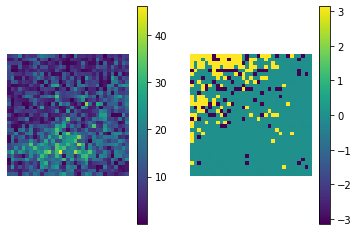

In [159]:
s = 33
a = torch.randn((s,s))
pad = s//2
a_pad = torch.nn.functional.pad(a, [pad]*4, value=0)
b = torch.rand((s,s))
b_pad = torch.nn.functional.pad(b, [pad]*4, value=0)
result_1 = convolve(a, b, 'same')
a_pad_k1 = torch.fft.fft2(a_pad)
b_pad_k1 = torch.fft.fft2(b_pad)
result_pad_k = a_pad_k1 * b_pad_k1
result_2 = torch.fft.ifftshift(torch.fft.ifft2(result_pad_k))[pad:pad+s,pad:pad+s]
 
print(f"complex conv:\n{result_1}", f"result-fft-(de)-ifft-ifftshift:\n{result_2}", sep="\n\n")

plot.figure(3)
plot.subplot(121)
plot.imshow(result_2.abs())
plot.axis("off")
plot.colorbar()
plot.subplot(122)
plot.imshow(result_2.angle())
plot.axis("off")
plot.colorbar()
"""
出现相位是因为误差, 对于负数如果存在一点点虚部分那么相位就会是接近-pi    
"""